# **Automatic Music Transcription**

##### This notebook demonstrates running the model on user-supplied recordings

###### This colab notebook is self-contained and should run natively on google cloud. The code and checkpoints can be downloaded separately and run locally, which is recommended if you want to train your own model.

## **Environment Setup**

In [3]:
#some hidden code to install and import all the packages required to run the model
# @title Setting Up Environment
import tensorflow as tf
import numpy as np
!pip install midiutil
import matplotlib.pyplot as plt
import io
from google.colab import files
import librosa
!pip install mido
import mido
from midiutil.MidiFile import MIDIFile
import pandas as pd
import string
import os
import sys
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
!pip install mido
import mido

from midiutil.MidiFile import MIDIFile
!pip install pretty_midi
import pretty_midi
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
!pip install libfmp
import string
from matplotlib import patches
from matplotlib import colors
import IPython.display as ipd
sys.path.append('..')
import libfmp.c1
# all additional codes
# @title All additional codes
pretty_midi.pretty_midi.MAX_TICK = 1e1000
# code to plot an midi
def plot_piano_roll(pm, start_pitch, end_pitch, sr=16000,Color = 'virdis'):
    plt.figure(figsize=(26, 7))
    librosa.display.specshow(pm.get_piano_roll(sr)[start_pitch:end_pitch],
                             hop_length=1, sr=sr, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch),
                             fmax=pretty_midi.note_number_to_hz(end_pitch),
                             cmap = Color)
    


# code to conver array to mid
def lol(arr2):
  [x,y]=arr2.shape
  arr3 = np.zeros((y,x,2), dtype=int)
    #Array to store the start and end times of each note played in key 
  start=1
  k=0 
  for j in range(arr2.shape[1]):
     for i in range(arr2.shape[0]):
          if arr2[i,j]==1 and start==1:
              arr3[j,k,0]=i
              start=0
          elif arr2[i,j]==0 and start==0:
              arr3[j,k,1]=i
              start=1
              k+=1
     k=0

  #Array to store the end times of each key 
  arr4=np.zeros((88), dtype=int)
  for i in range(arr3.shape[0]):
    for j in range(arr3.shape[1]):
      if arr3[i,j,0]==0:
        arr4[i]=j
        break
  return[arr3,arr4]

def arr_to_midi(source_array,duration_array,filename_):
  mf = MIDIFile(1,deinterleave=False)
  track = 0   
  time = 0
  channel = 0
  volume = 30
  delta = 0.03125
  mf.addTrackName(track, time, filename_)
  mf.addTempo(track, time, 60)

  for i in range(source_array.shape[0]):
    for j in range(duration_array[i]):
              pitch = i + 21
              time = delta*source_array[i,j,0]
              duration = delta*( source_array[i,j,1] - source_array[i,j,0] ) 
              mf.addNote(track, channel, pitch, time, duration, volume)
  with open(filename_+".mid", 'wb') as outf:
    mf.writeFile(outf)
  return mf

#NOW WE CLEAN THE MODEL. THIS STEP IS NOT NECESSARY AND TAKES A LOT OF TIME SINCE THERE WILL BE A LOT OF ITERATIONS.
#SINCE OUR TIME FRAME IS SMALL WE CONSIDER LIMITS OF HUMAN CAPABILITY IN MODIFYING SOME OUTPUTS.
def clean_midi(prediction_bool):
  for a in range(prediction_bool.shape[1]):
      for j in range(2,prediction_bool.shape[0]-3):
          if  prediction_bool[j-1,a] == 1 and prediction_bool[j,a] == 0 and prediction_bool[j+1,a] == 0 and prediction_bool[j+2,a] == 1:
              prediction_bool[j,a] = 1
              prediction_bool[j+1,a] = 1
          if prediction_bool[j-2,a] == 0 and prediction_bool[j-1,a] == 0 and prediction_bool[j,a] == 1 and prediction_bool[j+1,a] == 1 and prediction_bool[j+2,a] == 0 and prediction_bool[j+3,a] == 0:
              prediction_bool[j,a] = 0
              prediction_bool[j+1,a] = 0
          if prediction_bool[j-1,a] == 0 and prediction_bool[j,a] == 1 and prediction_bool[j+1,a] == 0 and prediction_bool[j+2,a] == 0:
              prediction_bool[j,a] = 0
          if prediction_bool[j-1,a] == 1 and prediction_bool[j,a] == 0 and prediction_bool[j+1,a] == 1 and prediction_bool[j+2,a] == 1:
              prediction_bool[j,a] = 1
  return prediction_bool

In [1]:
# @title Mounting google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## **Model Loading**

In [4]:
#code to load model
# @title Initialising Model
MODEL = tf.keras.models.load_model("/content/drive/MyDrive/my_rnnmodel.h5")

## **Upload Audio**

###### The audio will be trimmed to a length of 60 sec because it is just form demonstration that our model is working properly.

Audio upload saves the boolean array with the name Output.npy
and array name is prediction_bool

In [10]:
# code to upload an audio
# @title Audio Upload
uploaded = files.upload()

to_process = []
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  wav_data = uploaded[fn]

# code to preprocess the audio for using in model                  ##completed
sr = 16000
bins_per_octave=36
n_octave=7
n_bins=n_octave*bins_per_octave

x, t = librosa.load("{}".format(fn),sr=sr)
x = x[:sr*120]
CQT_spectrum = librosa.core.cqt(x, sr=sr,fmin=(librosa.note_to_hz('A0')), n_bins=n_bins, bins_per_octave=bins_per_octave,scale=False)
CQT = np.transpose(np.abs(CQT_spectrum))

max_shape = (CQT.shape[0]//100)*100
CQT = CQT[:max_shape,:]
CQT = CQT.reshape(CQT.shape[0]//100, 100, 252)

# code to input audio into model                   
prediction = MODEL.predict(x = CQT)
prediction = prediction.reshape(prediction.shape[0]*100,88)
prediction_bool = prediction>=0.5
np.save(fn[:-4]+".npy",prediction_bool)


Saving MAPS_MUS-alb_se2_ENSTDkCl.wav to MAPS_MUS-alb_se2_ENSTDkCl.wav
User uploaded file "MAPS_MUS-alb_se2_ENSTDkCl.wav" with length 42097020 bytes


## **Results**

#### **Original Audio**

In [11]:
# Play original audio of 60 sec       #completed
# @title Original Audio
ipd.display(ipd.Audio(data= x, rate=sr))

###### **without post-processing**

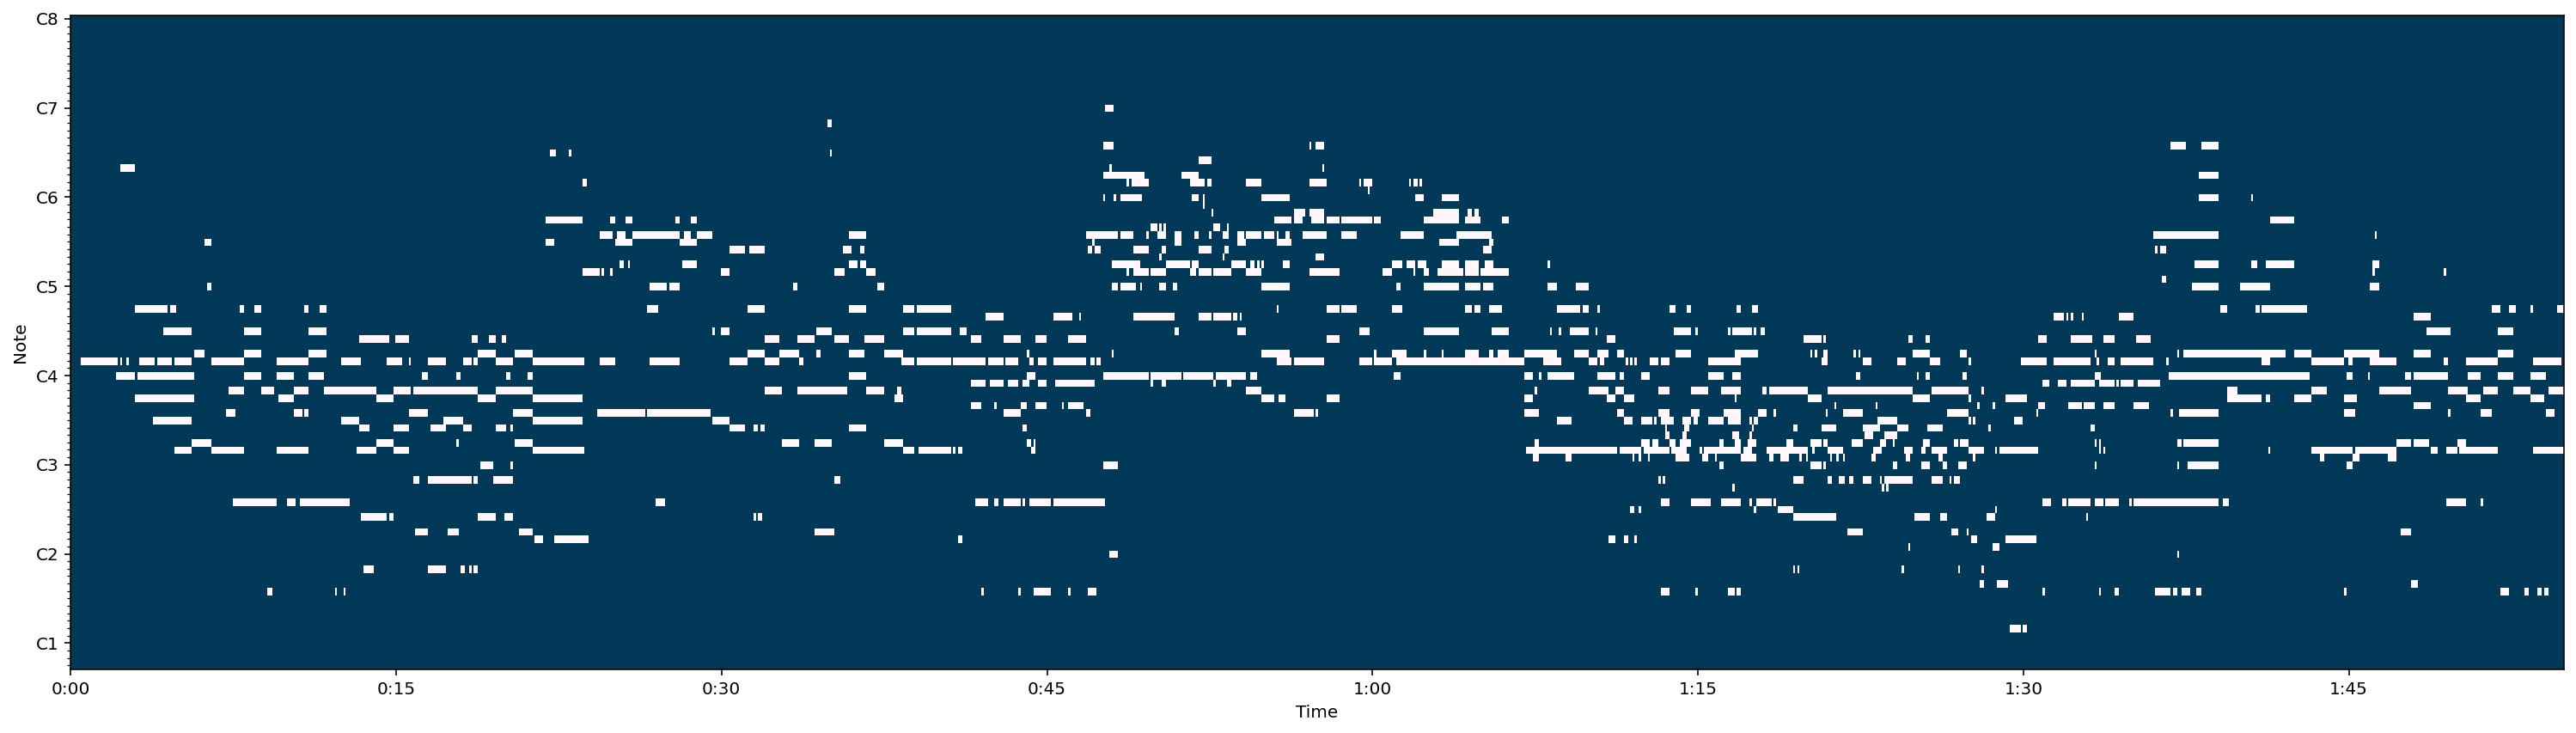

In [12]:
# predicted mid plot
# @title Predicted piano-roll representation
rnn_predictions = np.load("{}.npy".format(fn[:-4]))

arr5,arr6=lol(rnn_predictions)

mf=arr_to_midi(arr5,arr6,fn[:-4])

midi_data = pretty_midi.PrettyMIDI("{}.mid".format(fn[:-4]))

plot_piano_roll(midi_data,21,109,10,"PuBu_r")

###### **after post-processing**

/usr/local/lib/python3.7/dist-packages/librosa/display.py:1336: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  "Frequency axis exceeds Nyquist. "


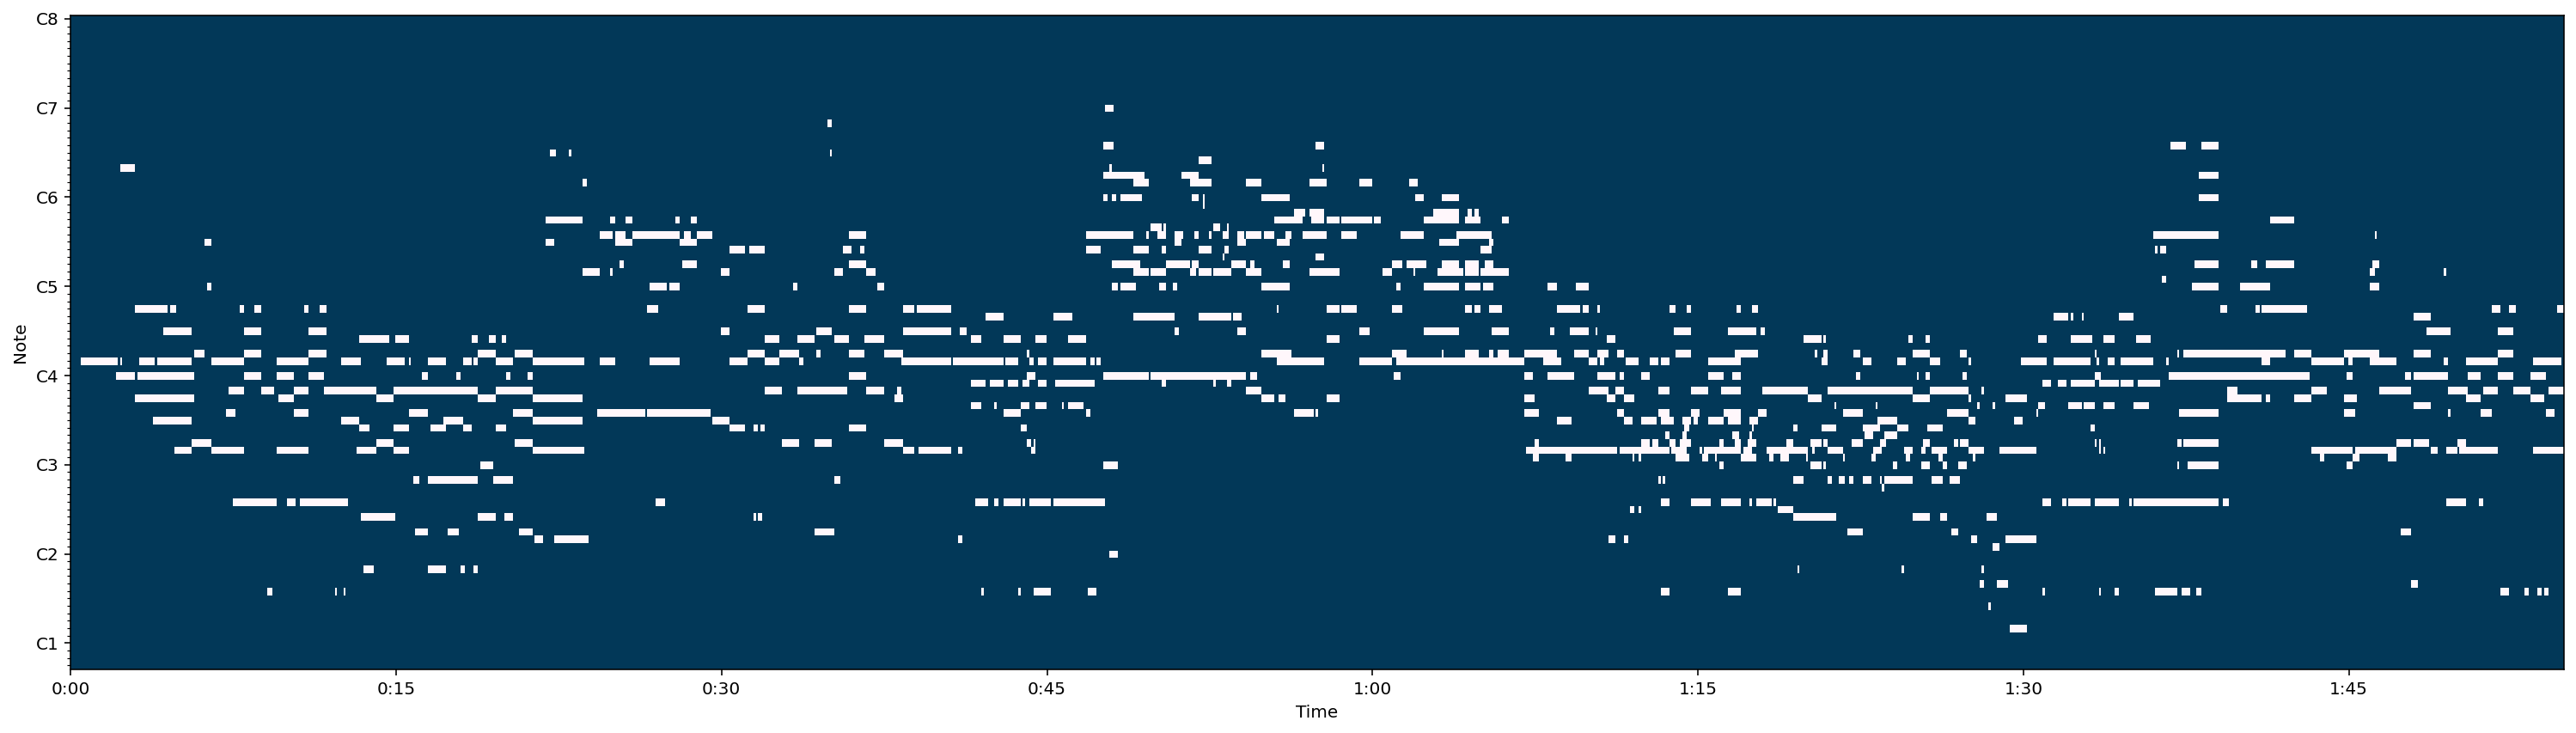

In [16]:
# predicted mid plot
# @title Predicted piano-roll representation
# function to plot a midi
rnn_predictions = np.load("{}.npy".format(fn[:-4]))

cleaned_midi_data = clean_midi(rnn_predictions)

arr5,arr6=lol(cleaned_midi_data)

mf=arr_to_midi(arr5,arr6,"cleaned_"+fn[:-4])

clean_midi_data = pretty_midi.PrettyMIDI("cleaned_"+"{}.mid".format(fn[:-4]))

plot_piano_roll(clean_midi_data,21,109,10,"PuBu_r")

In [19]:
np.save("clean_midi.npy",cleaned_midi_data)